In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.applications import VGG16

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 6000 files belonging to 500 classes.
Using 4800 files for training.
Metal device set to: Apple M1


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [7]:
from keras.applications.vgg16 import VGG16

def resnet_model_tf(input_shape=(128, 128, 3), nombre_classes=500):
    resnet = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    resnet.tbatch_sizenable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
    return model, learning_rate_reduction

In [8]:
model, learning_rate_reduction = resnet_model_tf()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2

In [9]:
epochs = 20
batch = 32

print("\n ================= Training : RESNET model ================= \n")
print("             Epochs :  {}   |   Batch size : {} ".format(epochs, batch))
print("\n =========================================================== \n")
trained = model.fit(train_ds, validation_data = val_ds, epochs=epochs, batch_size=batch, callbacks=[learning_rate_reduction])


 ================= Training : RESNET model ================= 

             Epochs :  20   |   Batch size : 32 


Epoch 1/20
150/150 [==============================] - 154s 1s/step - loss: 6.9446 - accuracy: 0.0012 - val_loss: 6.2250 - val_accuracy: 0.0000e+00
Epoch 2/20
150/150 [==============================] - 152s 1s/step - loss: 6.2230 - accuracy: 0.0012 - val_loss: 6.2303 - val_accuracy: 0.0000e+00
Epoch 3/20
150/150 [==============================] - 152s 1s/step - loss: 6.2152 - accuracy: 0.0023 - val_loss: 6.2421 - val_accuracy: 0.0000e+00

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 4/20
150/150 [==============================] - 153s 1s/step - loss: 6.2073 - accuracy: 0.0023 - val_loss: 6.2590 - val_accuracy: 0.0000e+00
Epoch 5/20
150/150 [==============================] - 152s 1s/step - loss: 6.2060 - accuracy: 0.0019 - val_loss: 6.2781 - val_accuracy: 0.0000e+00

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000490000

In [10]:
val = model.evaluate(test_ds)
input_shape = (128, 128, 3)

print("\n ================= Evaluation : Resnet model ================= \n")
print("  With : \n")
print("Batch size         :  {}     |   Epochs      : {} ".format(batch, epochs))
print("Nombres de classes :  {}    |   Input shape : {} \n".format(len(train_ds.class_names), input_shape))
print("\n ============================================================= \n")

print("  Results : \n")
print("Loss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

29/29 [==============================] - 7s 235ms/step - loss: 6.2979 - accuracy: 0.0000e+00

 ================= Evaluation : Resnet model ================= 

  With : 

Batch size         :  32     |   Epochs      : 20 
Nombres de classes :  500    |   Input shape : (128, 128, 3) 



  Results : 

Loss  : 629.79%
Score : 0.00%


In [ ]:
!mkdir -p saved_model
model.save('saved_model/vgg19.h5')

In [ ]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            X.append(np.array(img))
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [ ]:
X, y, label_names = load_img(path_data, nb_of_users=50, xdim=224, ydim=224)

In [ ]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))
print("\n\n-----------------------------------------")
print("Il y a {} utilisateur(s) dans le dataset prélevé.".format(y.shape[1]))

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("------------------------------------------------------------------------------")
print("(X_temp shape : {}    |   y_temp shape : {})\n".format(X_temp.shape, y_temp.shape))



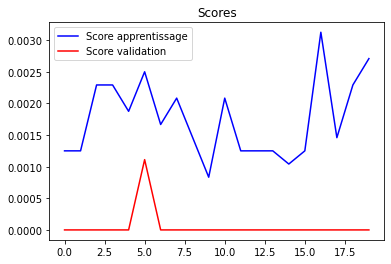

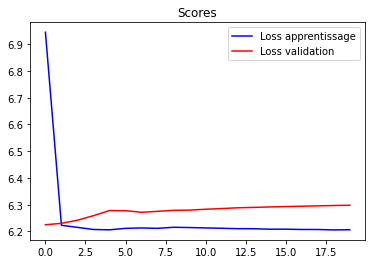

In [11]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
    
plot_scores(trained)
plot_loss(trained)

In [ ]:
plot_scores(trained)
predict_x = model.predict(X_test)
y_cnn = np.argmax(predict_x, axis=1)
plt.figure(figsize=(15, 25))
n_test = X_test.shape[0]
i = 1
for j in range(len(X_test)):
    if (y_cnn[j] != y_test[j].argmax(axis=-1)) & (i < 10):
        plt.subplot(10, 5, i)
        plt.axis('off')
        plt.imshow(X_test[j])
        plt.title('%s / %s' % (Classes[y_cnn[j]], Classes[y_test[j].argmax(axis=-1)]))
        i += 1
plt.show()